<a href="https://colab.research.google.com/github/Marwan-Aj/PMASD/blob/main/AE_slider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import glob 
import joblib
import os
import re
import librosa
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dropout, Reshape, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense
from tensorflow.keras import Model,layers, losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from keras.utils.vis_utils import plot_model
from keras.backend import int_shape

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import itertools

## Import des données

In [ ]:
PATH = './drive/MyDrive/PMASD/'
machine = 'slider'

dtrain = PATH + machine + '/train/*.wav'
dtest = PATH + machine+ '/test/*.wav'

def load_df(path) :
  liste = glob.glob(path)
  df = pd.DataFrame(liste, columns=['filepath'])
  df['id'] = df['filepath'].apply(lambda x: re.findall(r"[0-9]{2}", x)[0])
  df['label'] = df['filepath'].apply(lambda x: str(re.findall(r"(normal|anomaly)", x)[0])).replace({'normal':0, 'anomaly':1})
  return df

df_train = load_df(dtrain)
df_test = load_df(dtest)


df_test.sample(6)

,filepath,id,label
44,./drive/MyDrive/PMASD/slider/test/anomaly_id_0...,02,1
916,./drive/MyDrive/PMASD/slider/test/normal_id_06...,06,0
174,./drive/MyDrive/PMASD/slider/test/anomaly_id_0...,02,1
936,./drive/MyDrive/PMASD/slider/test/normal_id_06...,06,0
351,./drive/MyDrive/PMASD/slider/test/anomaly_id_0...,04,1
73,./drive/MyDrive/PMASD/slider/test/anomaly_id_0...,02,1


In [ ]:
def load_audio(audio_path):
    audio, fe = librosa.load(audio_path, sr=None, duration=10)  # limiter l'import d'audio à 10sec
    return audio, fe 

params = {'n_mels': 128,
          'n_fft': 1024,
          'hop_length': 512,
          'power': 2.0}


## Génération des features

In [ ]:
def get_features(file_name,
                 n_mels=params['n_mels'],
                 n_fft=params['n_fft'],
                 hop_length=params['hop_length'],
                 power=params['power']):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # load audio
    audio, fe = load_audio(file_name)
    
    # generate melspectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio,
                                                     sr=fe,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)
    # MFECs
    log_mel_energy = librosa.core.power_to_db(mel_spectrogram)
       
    vector_array = log_mel_energy.T    # transpose for the time axis to be in axis=0  dim(313, 128)

    ## run only after scaler is fitted
    vector_array = scaler.transform(vector_array)

            
    return vector_array

In [ ]:
## uncomment to compute scaler
scaler = preprocessing.StandardScaler()

In [ ]:
def create_vectors(file_list,
                   msg="calc...",
                   n_mels=params['n_mels'],
                   n_fft=params['n_fft'],
                   hop_length=params['hop_length'],
                   power=params['power']):
  """
  convert the file_list to a vector array.
  get_features() is iterated, and the output vector array is concatenated.
    
  """

  # iterate get_features()
  for idx in tqdm(range(len(file_list)), desc=msg):
    vector_array = get_features(file_list[idx])

    ## uncomment to compute scaler
    #scaler.partial_fit(X=vector_array)

    if idx == 0:
      X = np.empty((len(file_list), vector_array.shape[0], vector_array.shape[1]))  # create X matrix
    X[idx,] = vector_array
        
  return X

In [ ]:
# compute scaler (uncomment the 2 function (define scaler & partial_fit) and comment the transform in function get_features)
m = create_vectors(list(df_train.filepath))


calc...: 100%|██████████| 2804/2804 [26:07<00:00,  1.79it/s]


In [ ]:
scaler_name = 'scaler_'+ machine +'.gz'
#save scaler
joblib.dump(scaler, PATH+scaler_name)

# to load:
#scaler = joblib.load(PATH+scaler_name)

['./drive/MyDrive/PMASD/scaler_slider.gz']

In [ ]:
# Data Loader & crop

class DataGenerator(utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_data, batch_size=32, dim=(32,128), shuffle=True, step=8):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.data = list_data
        
        self.step = step
        self.indexes_start = np.arange(self.data.shape[1]-self.dim[0]+self.step, step=self.step)
        self.max = len(self.indexes_start)
        self.indexes = np.arange(self.data.shape[0])
        
        self.indexes = np.repeat(self.indexes, self.max )
        self.indexes_start = np.repeat(self.indexes_start, self.data.shape[0])
    
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data.shape[0] * self.max  / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        indexes_start = self.indexes_start[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X = self.__data_generation(indexes, indexes_start).reshape((self.batch_size, *self.dim, 1))

        return X, X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            np.random.shuffle(self.indexes_start)


    def __data_generation(self, indexes, index_start):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, (id_file, id_start) in enumerate(zip(indexes, index_start)):

            x = self.data[id_file,]
            length, mels = x.shape

            start = id_start

            start = min(start, length - self.dim[0])
            
            # crop part of sample
            crop = x[start:start+self.dim[0], :]

            X[i,] = crop
        return X

In [ ]:
path_train, path_val = train_test_split(list(df_train.filepath), test_size=0.1, random_state=1)

list_files_train = create_vectors(path_train)
list_files_val = create_vectors(path_val)

calc...: 100%|██████████| 281/281 [00:03<00:00, 72.84it/s]


In [ ]:
shape0_feat = 32
shape1_feat = params['n_mels']
batch_size = 64

# load data 
gen_train = DataGenerator(list_files_train, batch_size=batch_size, dim=(shape0_feat,shape1_feat), step=3)
gen_val = DataGenerator(list_files_val,  batch_size=batch_size, dim=(shape0_feat,shape1_feat), shuffle=False, step=3)

## Modèle

In [ ]:

def get_data_shape(layer):
    return tuple(int_shape(layer)[1:])


def get_model(inputDim, latentDim):
    """
    define the keras model
    the model based on the simple convolutional auto encoder 
    """
    input_img = Input(shape=(inputDim[0], inputDim[1], 1)) 

    # encoder
    x = Conv2D(32, (5, 5),strides=(1,2), padding='same')(input_img)   #32x128 -> 32x64
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.4)(x)
    x = Conv2D(64, (5, 5),strides=(1,2), padding='same')(x)           #32x32
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.4)(x)
    x = Conv2D(128, (5, 5),strides=(2,2), padding='same')(x)          #16x16
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.4)(x)
    x = Conv2D(256, (3, 3),strides=(2,2), padding='same')(x)          #8x8
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.4)(x)
    x = Conv2D(512, (3, 3),strides=(2,2), padding='same')(x)          #4x4
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.4)(x)

    volumeSize = int_shape(x)
    # at this point the representation size is latentDim i.e. latentDim-dimensional
    x = Conv2D(latentDim, (4,4), strides=(1,1), padding='valid')(x)
    encoded = Flatten()(x)
        
    # decoder
    x = Dense(volumeSize[1] * volumeSize[2] * volumeSize[3])(encoded) 
    x = Reshape((volumeSize[1], volumeSize[2], 512))(x)                #4x4

    x = Conv2DTranspose(256, (3, 3),strides=(2,2), padding='same')(x)  #8x8
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.4)(x)
    x = Conv2DTranspose(128, (3, 3),strides=(2,2), padding='same')(x)  #16x16   
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.4)(x)
    x = Conv2DTranspose(64, (5, 5),strides=(2,2), padding='same')(x)   #32x32
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.4)(x)
    x = Conv2DTranspose(32, (5, 5),strides=(1,2), padding='same')(x)   #32x64
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.4)(x)
    
    decoded = Conv2DTranspose(1, (5, 5),strides=(1,2), padding='same')(x) 

    return Model(inputs=input_img, outputs=decoded)


model = get_model((shape0_feat, shape1_feat),40)
model.summary() 

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss = 'mse')



#callbacks
folder = 'modelsAE'
subf = machine
path_model = os.path.join(PATH, folder, subf)
#os.makedirs(path_model)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         verbose = 2,
                                         mode = 'min')

early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 10,
                                         mode = 'min',
                                         restore_best_weights = True) 

checkpoint = callbacks.ModelCheckpoint(filepath = path_model,
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 64, 32)        832       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 64)        0   

In [ ]:
#train
history = model.fit(gen_train,
                    validation_data=gen_val,
                    epochs=100,
                    callbacks=[lr_plateau, early_stopping, checkpoint])

Epoch 1/100
3745/3745 [==============================] - 216s 56ms/step - loss: 0.4226 - val_loss: 0.3723
INFO:tensorflow:Assets written to: ./drive/MyDrive/PMASD/modelsAE/slider/assets
Epoch 2/100
3745/3745 [==============================] - 214s 57ms/step - loss: 0.3534 - val_loss: 0.3564
INFO:tensorflow:Assets written to: ./drive/MyDrive/PMASD/modelsAE/slider/assets
Epoch 3/100
3745/3745 [==============================] - 214s 57ms/step - loss: 0.3471 - val_loss: 0.3506
INFO:tensorflow:Assets written to: ./drive/MyDrive/PMASD/modelsAE/slider/assets
Epoch 4/100
3745/3745 [==============================] - 214s 57ms/step - loss: 0.3437 - val_loss: 0.3480
INFO:tensorflow:Assets written to: ./drive/MyDrive/PMASD/modelsAE/slider/assets
Epoch 5/100
3745/3745 [==============================] - 214s 57ms/step - loss: 0.3415 - val_loss: 0.3467
INFO:tensorflow:Assets written to: ./drive/MyDrive/PMASD/modelsAE/slider/assets
Epoch 6/100
3745/3745 [==============================] - 214s 57ms/ste

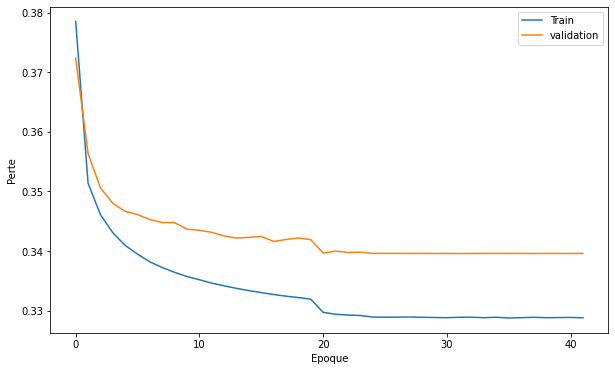

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.xlabel('Epoque')
plt.ylabel('Perte')
plt.legend()
plt.show()

## Évaluation du modèle

In [ ]:
# prédiction X_test
y_test = np.array(df_test.label)

test_pred = [0. for k in range(len(df_test))]

for file_idx, file_path in tqdm(enumerate(df_test.filepath), total=len(df_test)):

    # get audio features and normalise (scaler.transform must be active in get_features)
    vector_array = get_features(file_path)

    length, _ = vector_array.shape
    dim = 32
    step = 3
    idex = np.arange(length-dim+step, step=step)
    for idx in range(len(idex)):
        start = min(idex[idx], length - dim)
        vector = vector_array[start:start+dim,:]
        vector = vector.reshape((1, vector.shape[0], vector.shape[1]))
        if idx==0:
            batch = vector
        else:
            batch = np.concatenate((batch, vector))

    # add channels dimension
    data = batch.reshape((batch.shape[0], batch.shape[1], batch.shape[2], 1))
    # calculate predictions
    errors = np.mean(np.square(data - model.predict(data)), axis=-1)
    test_pred[file_idx] = np.mean(errors)
    


100%|██████████| 1290/1290 [11:30<00:00,  1.87it/s]


AUC machine: 0.9231


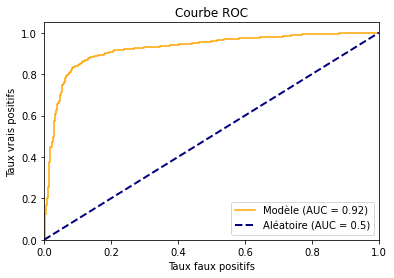

In [ ]:
test_pred = np.array(test_pred)

AUC_score = roc_auc_score(y_test, test_pred)
print('AUC machine:', AUC_score.round(4))

fpr, tpr, seuils = metrics.roc_curve(y_test, test_pred, pos_label=None)

plt.plot(fpr, tpr, color='orange', label='Modèle (AUC = %0.2f)' % AUC_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (AUC = 0.5)')
plt.axis([0.0, 1.0, 0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compared to metrics such as the subset accuracy, the Hamming loss, or the F1 score, ROC doesn’t require optimizing a threshold for each label
# https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

In [ ]:
# AUC calculé par ID machine

idx_00 = df_test.index[df_test.id=='00']
idx_02 = df_test.index[df_test.id=='02']
idx_04 = df_test.index[df_test.id=='04']
idx_06 = df_test.index[df_test.id=='06']

y_test_00 = df_test.label[idx_00]
y_test_02 = df_test.label[idx_02]
y_test_04 = df_test.label[idx_04]
y_test_06 = df_test.label[idx_06]

test_pred_00 = test_pred[idx_00]
test_pred_02 = test_pred[idx_02]
test_pred_04 = test_pred[idx_04]
test_pred_06 = test_pred[idx_06]

In [ ]:
def calculate_auc(y_test_idx, test_pred_idx):
  
  AUC_sc = roc_auc_score(y_test_idx, test_pred_idx).round(4)
  print('AUC:', AUC_sc)
  return AUC_sc

In [ ]:
# AUC du modèle pour chaque ID machine
AUC_00 = calculate_auc(y_test_00, test_pred_00)

AUC: 0.9905


In [ ]:
AUC_02 = calculate_auc(y_test_02, test_pred_02)

AUC: 0.8386


In [ ]:
AUC_04 = calculate_auc(y_test_04, test_pred_04)

AUC: 0.9729


In [ ]:
AUC_06 = calculate_auc(y_test_06, test_pred_06)

AUC: 0.869


## Prédiction des labels

In [ ]:
# load model from file
model = tf.saved_model.load(path_model+'/')

### Calcul du seuil

In [ ]:
# Prédiction des données d'entraînement pour définir le seuil

# L'entrée à l'entraînement du modèle est un génerateur. 
# Pour connaître la prédiction du modèle pour l'ensemble complet de train on doit faire le même process que pour test

perte = [0. for k in range(len(df_train))]

for file_idx, file_path in tqdm(enumerate(df_train.filepath), total=len(df_train)):

    # audio features and normalise (scaler.transform must be active in get_features)
    vector_array = get_features(file_path)

    length, _ = vector_array.shape
    dim = 32
    step = 3
    idex = np.arange(length-dim+step, step=step)
    for idx in range(len(idex)):
        start = min(idex[idx], length - dim)
        vector = vector_array[start:start+dim,:]
        vector = vector.reshape((1, vector.shape[0], vector.shape[1]))
        if idx==0:
            batch = vector
        else:
            batch = np.concatenate((batch, vector))

    # add channels dimension
    data = batch.reshape((batch.shape[0], batch.shape[1], batch.shape[2], 1))
    # calculate predictions
    mse = np.mean(np.square(data - model(data)), axis=-1)
    perte[file_idx] = np.mean(mse)

100%|██████████| 2804/2804 [02:14<00:00, 20.91it/s]


In [ ]:
perte = np.array(perte)

# calcul du seuil
seuil_90 = np.percentile(perte, 90)
seuil_95 = np.percentile(perte, 95)
seuil_avg = np.mean(perte)

In [ ]:
def metriques(y_test, test_pred, seuil):
  test_df = pd.DataFrame({
      'real_class': y_test,
      'predicted_class': [1 if error>seuil else 0 for error in test_pred]})

  # Matrice de confusion
  print(pd.crosstab(test_df['real_class'], test_df['predicted_class']),'\n')

  print(metrics.classification_report(test_df['real_class'], test_df['predicted_class']))


metriques(y_test, test_pred, seuil_90)

predicted_class    0    1
real_class               
0                318   82
1                 81  809 

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       400
           1       0.91      0.91      0.91       890

    accuracy                           0.87      1290
   macro avg       0.85      0.85      0.85      1290
weighted avg       0.87      0.87      0.87      1290



In [ ]:
metriques(y_test, test_pred, seuil_95)

predicted_class    0    1
real_class               
0                341   59
1                104  786 

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       400
           1       0.93      0.88      0.91       890

    accuracy                           0.87      1290
   macro avg       0.85      0.87      0.86      1290
weighted avg       0.88      0.87      0.88      1290



In [ ]:
metriques(y_test, test_pred, seuil_avg)

predicted_class    0    1
real_class               
0                188  212
1                 31  859 

              precision    recall  f1-score   support

           0       0.86      0.47      0.61       400
           1       0.80      0.97      0.88       890

    accuracy                           0.81      1290
   macro avg       0.83      0.72      0.74      1290
weighted avg       0.82      0.81      0.79      1290

